In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from helpers2 import *
from preprocessing import *

In [3]:
#data_folder = Path("../data/")
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [89]:
print(y)
print(np.shape(y))
print(np.shape(tX))
print(tX.dtype)
print(y.dtype)

[ 1. -1. -1. ...  1. -1. -1.]
(250000,)
(250000, 30)
float64
float64


In [90]:
feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
                 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
                 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
                 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
                 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

for i, name in enumerate(feature_names):
    print(i, feature_names[i])


0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


The training data set is composed of : 
* a y vector of length 250'000 and type float
* a tX float matrix of 250'000 rows and 30 columns

It means that our data set is composed of 250'000 different obsevations of 30 different features. In the rest of the notebook, we name the features by their index nummer. So, it means from the feature 0 from the feature  29.

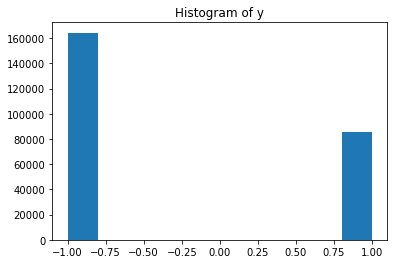

In [91]:
plt.hist(y)
plt.title('Histogram of y')
plt.show()

There is more y = -1 than y = 1 in the data, so there is more y = 'b' than y = 's'. So, we have to pay attention to normalize the data in order to compare them in the next plots.

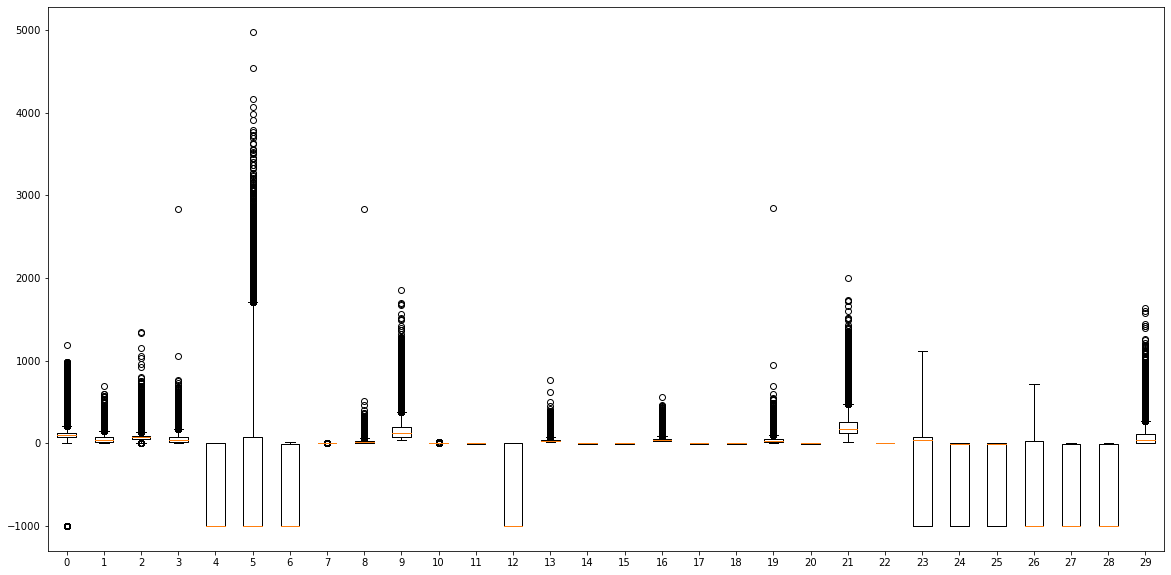

In [92]:
plt.figure(figsize=(20, 10))
ind = np.arange(30)
plt.boxplot(tX[:,], labels = ind)

plt.show()

There are many outliers depending on the feature. There are also feature that has a long interquantile range. Maybe we have to treat these feature in order to be more efficient in our futur predictions. Let's do more plots to be have a better idea :

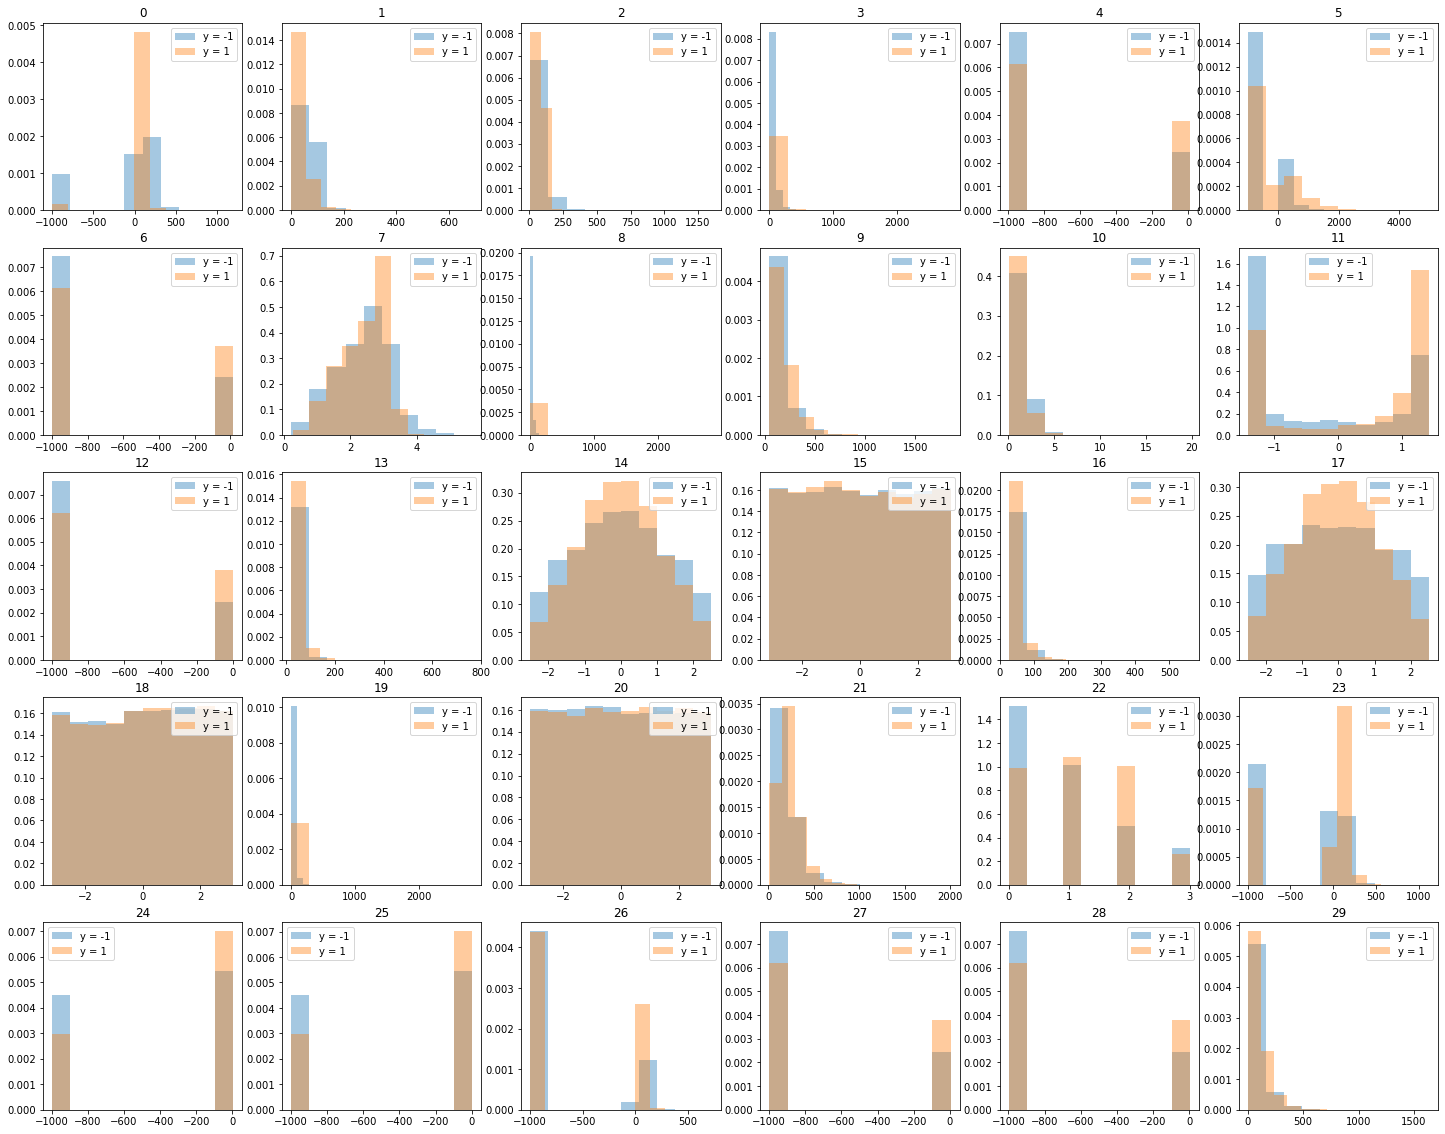

In [93]:
ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

fig, axs = plt.subplots(5, 6, figsize=(25,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
        axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
        axs[i,j].legend()
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

By plotting the histograms of the features with a color for each y, we can see that there are useless features as they have almost the same distribution for y=1 than for y = -1. We can cut feature 15, 18, 20. 


There are also features that are very inequally distributed with value that are about -1000 and values around 0 ; it can be problematic for the prediction with such a large gap between values of a single distribution. Moreover, there is not a big difference in the distribution of y=1 and y=-1. Maybe it can be useful to put off these big negative values of these features. The features in question are : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.


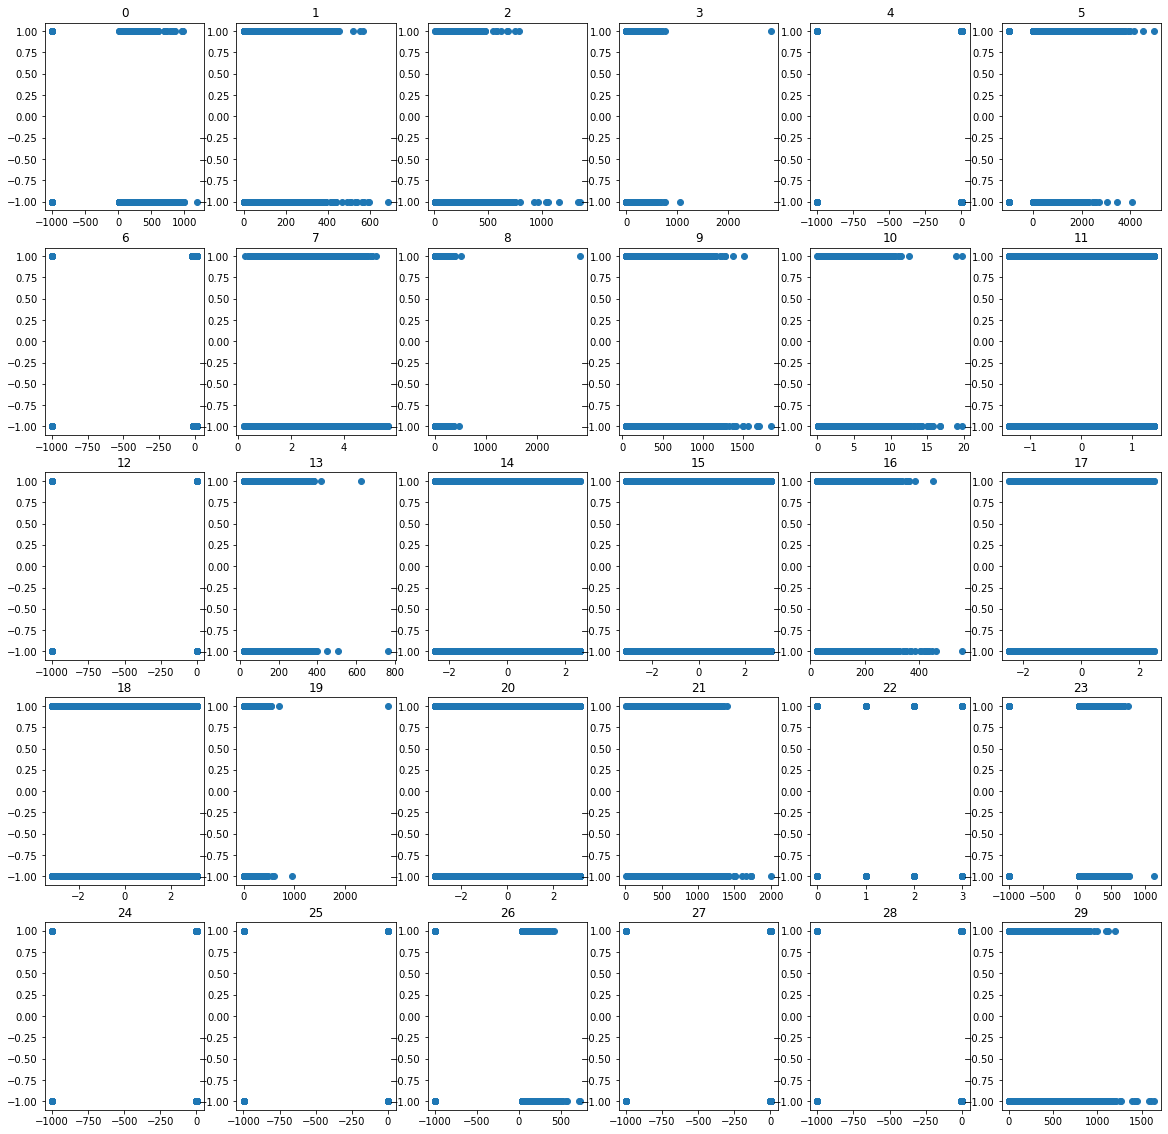

In [94]:
fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].scatter(tX[:,n], y)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

#meme constat comment faire pour se debarrasser de ces valeurs ??

These plots confirm the obsevations that we made in the previous plot ; no difference of the distribution of y for features 15, 18, 20 and very large gap in the distributions of features : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.

## Data filtering

### Outliers

In [96]:
def nb_outliers(tX, outlier) : 
    sum = 0
    nb_outliers = []
    for col in range(tX.shape[1]) :
        sum = np.where(tX[:,col] == outlier)[0].shape
        nb_outliers.append(sum)   
    print(nb_outliers)
    print(np.where(tX==outlier)[0].shape)

out = -999

print('number of -999 in the entire matrix :')
nb_outliers(tX, out)

ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

print('number of -999 in the rows where y = 1 :')
nb_outliers(tX_1, out)
print('number of -999 in the rows where y = -1 :')
nb_outliers(tX_2, out)

number of -999 in the entire matrix :
[(38114,), (0,), (0,), (0,), (177457,), (177457,), (177457,), (0,), (0,), (0,), (0,), (0,), (177457,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (99913,), (99913,), (99913,), (177457,), (177457,), (177457,), (0,)]
(1580052,)
number of -999 in the rows where y = 1 :
[(2835,), (0,), (0,), (0,), (53202,), (53202,), (53202,), (0,), (0,), (0,), (0,), (0,), (53202,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (25492,), (25492,), (25492,), (53202,), (53202,), (53202,), (0,)]
(451725,)
number of -999 in the rows where y = -1 :
[(35279,), (0,), (0,), (0,), (124255,), (124255,), (124255,), (0,), (0,), (0,), (0,), (0,), (124255,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (74421,), (74421,), (74421,), (124255,), (124255,), (124255,), (0,)]
(1128327,)


We have a problem with features  0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28. They are inequally distributed; they have a lot of -999 values and the rest is values around 0. So, here we can see how much of these -999 there are. We can see that the -999 appear only in the features that we identified with the histograms. It seems that there is a correlation between features as many features have the same number of -999. We can also see that there is more -999 in the obsevations where y=-1, so we have to take this into account when we filter the data. As there are many -999, we can't delete the rows where there is -999 because we will loose to much information.

Explication sets

In [9]:
def histograms(y, tX):
    ind_1 = np.where(y == 1)
    ind_2 = np.where(y == -1)
    tX_1 = tX[ind_1[0],:]
    tX_2 = tX[ind_2[0],:]

    fig, axs = plt.subplots(5, 6, figsize=(25,20))

    n = 0
    for i in range(5) :
        for j in range(6) :
            axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
            axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
            axs[i,j].legend()
            axs[i,j].set_title(n)
            n = n + 1
            if n>=tX.shape[1]: break
        if n>=tX.shape[1]: break
    plt.show()

In [7]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

print('Set 1')
set1_x = outliers(set1_x, -999)
_ = outliers(set1_x, -999)

print('\nSet 2')
set2_x = outliers(set2_x, -999)
_ = outliers(set2_x, -999)

print('\nSet 3')
set3_x = outliers(set3_x, -999)
_ = outliers(set3_x, -999)

Set 1
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 2
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 3
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Set 1
[False False False False False False False False False False False False
 False False False False False False]


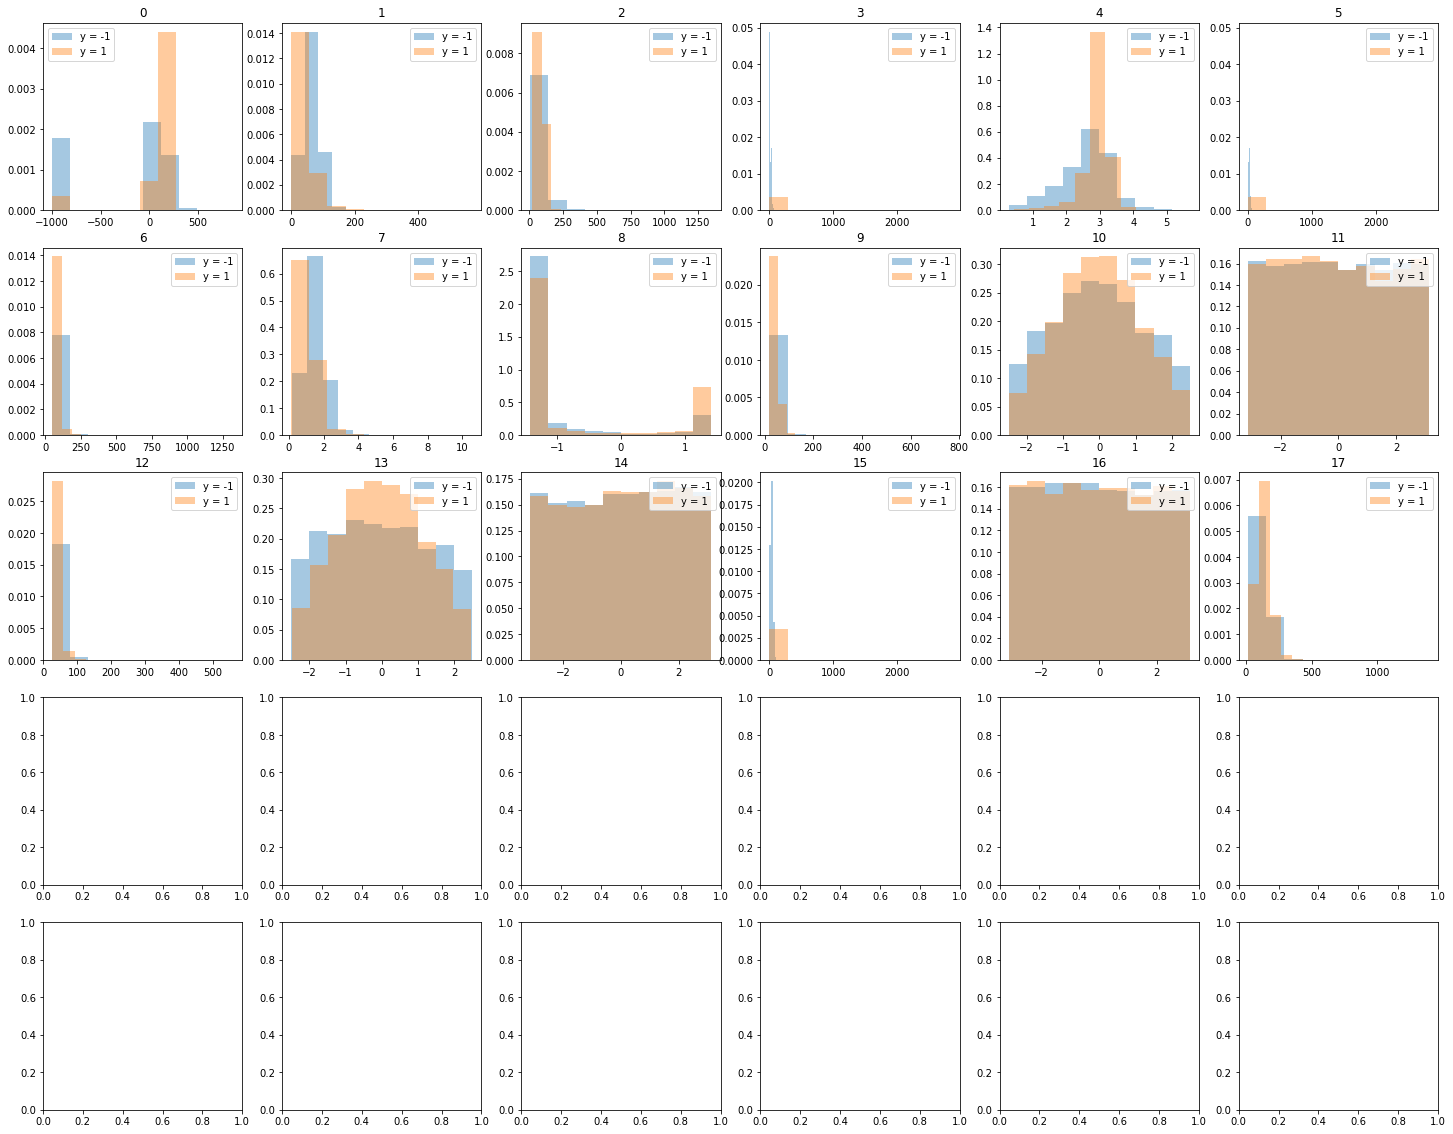


Set 2
[False False False False False False False False False False False False
 False False False False False False False False False False]


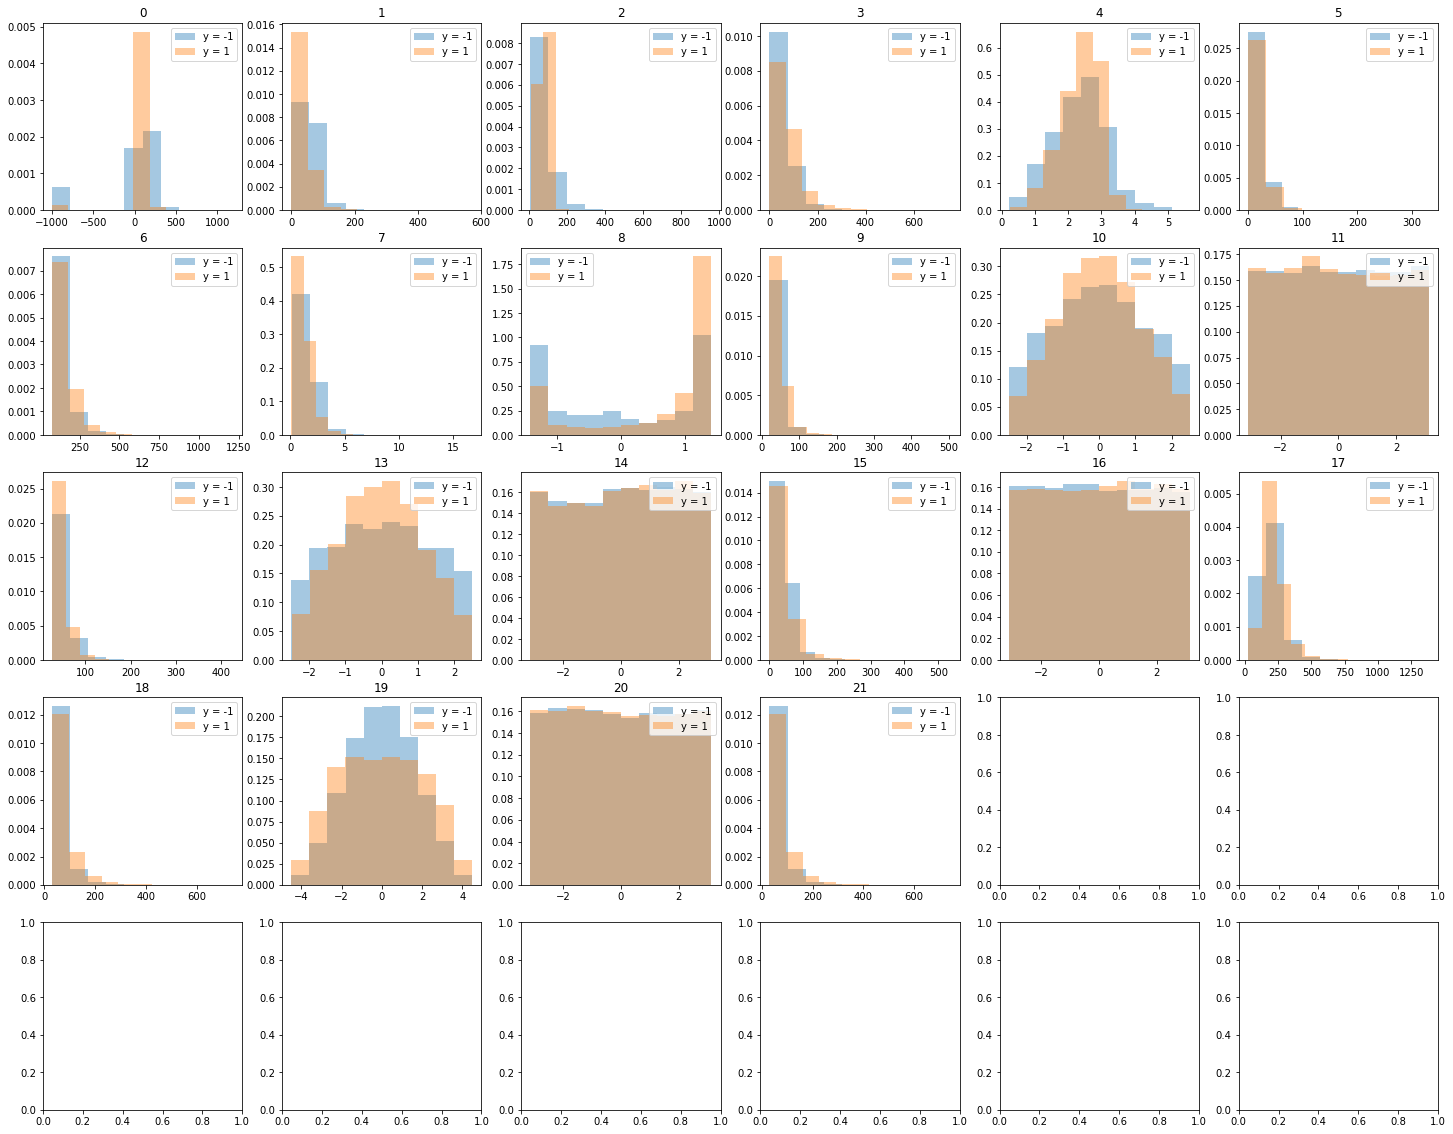


Set 3
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


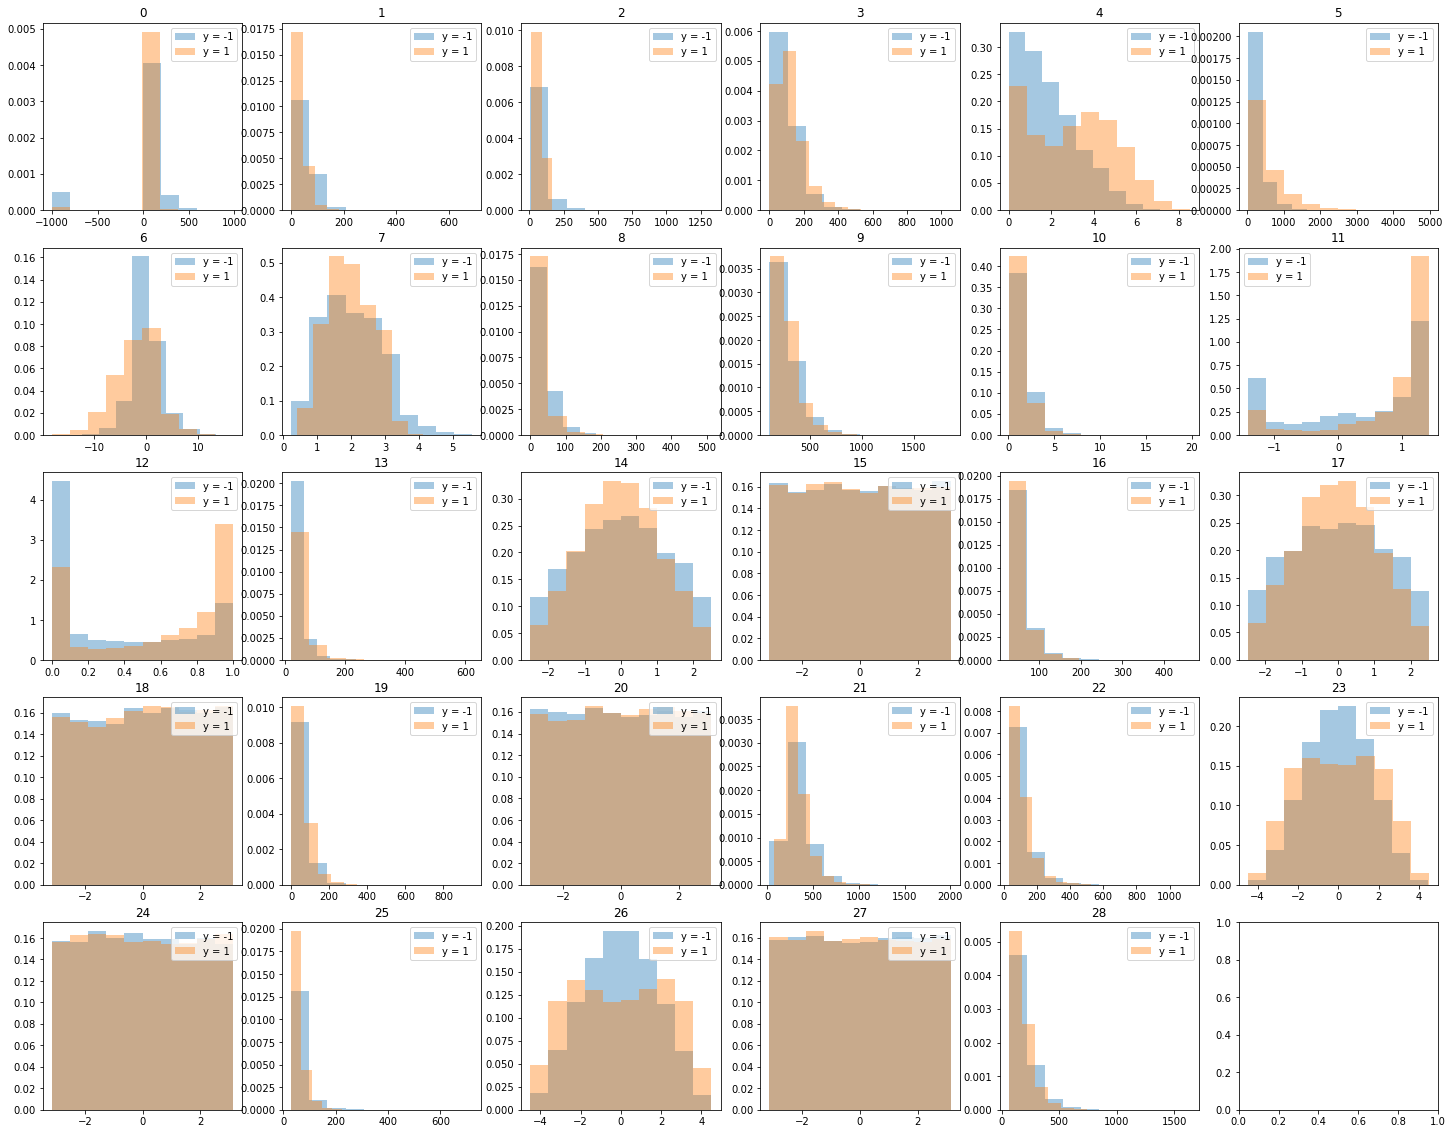

In [10]:
print('Set 1')
print(np.all(set1_x==set1_x[0], axis = 0))
histograms(set1_y, set1_x)

print('\nSet 2')
print(np.all(set2_x==set2_x[0], axis = 0))
histograms(set2_y, set2_x)

print('\nSet 3')
print(np.all(set3_x==set3_x[0], axis = 0))
histograms(set3_y, set3_x)

things to delete 

TEST FOR y=[0,1]

In [ ]:
print(y)
y[y==-1]=0
print(y)

In order to filter the data, we want to get rif of these -999, but we can't just delete the rows. So, we have the idea to replace the -999 by the mean of the rest of values of the feature. As there is a significant difference of amount of -999 in between y=1 and y=-1 in certain features, we calculate the mean for the rows where y = 1 and y = -1 separatly.

Then, we can also standardize the data. It can be a good idea because the features are not all in the same range of values and it can create disproportionality between the importance of the features.

As we see above in the histograms, some features seem to be useless as they have a similar distribution between the y = 1 and y = -1. So, it is useful to have function that cut or keep some parameters.

In [12]:
to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]
#to_log2 = [7, 8, 10, 11, 19]

## Fonctions 

In [13]:
from implementations import *
from cross_validation import *

### Least squares

The best results for least squares regression is with the tX matrix which is standardize, filter with filtering_with_mean_bis function and whose features 15, 18, 20 are cut :

In [ ]:
x_essai = x4
degrees = np.arange(1,11)
degree_opt, _ = best_degree_selection(y, x_essai, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
tX_poly = build_poly(x_essai, degree_opt)
w_ls, loss_ls = least_squares(y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_ls = degree_opt
#deg= ,test_rmse= 0.8094823719446076, train_rmse=0.5723030100580346

The least squares best model is degree 1 ; its accuracy is : 0.606

### Ridge regression 

The best results for Ridge regression is with tX that is only filtered by filtering_with_mean_bis function : 

In [ ]:
degrees = np.arange(1,8)
x_essai = x1
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
degree_rr = degree_opt

Let's look if we can improve the results with the separation of tX into sets according to the feature 22 (PRI_jet_num) : 

In [ ]:
set1_x_rr = filtering_with_mean_bis(set1_x, set1_y)

set2_x_rr = filtering_with_mean_bis(set2_x, set2_y)

set3_x_rr = filtering_with_mean_bis(set3_x, set3_y)

Ridge regression according to the different sets : 

In [ ]:
degrees = np.arange(1,8)
x_essai = set1_x_rr
y = set1_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set1, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set1 = lambda_opt
degree_rr_set1 = degree_opt

In [ ]:
degrees = np.arange(1,8)
x_essai = set2_x_rr
y = set2_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set2, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set2 = lambda_opt
degree_rr_set2 = degree_opt

In [ ]:
degrees = np.arange(1,8)
x_essai = set3_x_rr
y = set3_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set3, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set3 = lambda_opt
degree_rr_set3 = degree_opt

We have better results with the matrix that is separated in sets, so let's do a submission with this method. The submission is better without filtering_with_mean on the test sets. We had 0.802 of accuracy with the filtering_with_mean function and 0.804 without.

### Gradient descent

We process the data to get better results 

In [14]:
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

set1_x = outliers(set1_x, -999)
set1_x = filtering_with_mean_bis(set1_x_gd, set1_y)
#set1_x = normalize(set1_x_gd)
set1_x = std(set1_x_gd)

set2_x = outliers(set2_x, -999)
set2_x_gd = filtering_with_mean_bis(set2_x_gd, set2_y)
#set2_x_gd = normalize(set2_x_gd)
set2_x_gd = std(set2_x_gd)

set3_x = outliers(set3_x, -999)
set3_x = filtering_with_mean_bis(set3_x, set3_y)
#set2_x = normalize(set2_x)
set3_x = std(set3_x)

print("Preprocessing for gradient descent done!")

outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Preprocessing for gradient descent done!


In the next cells, we perform a 4-fold cross validation for the gamma parameter for gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set1_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt1 = cross_validation(set1_y, set1_x_gd, k_fold, gammas, fonction=2)
w_gd1, loss_gd1 = least_squares_GD(set1_y, set1_x_gd, gamma_opt1, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt1))
print("Gradient descent regression loss {loss}".format(loss=loss_gd1))

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.5
Gradient Descent(2/49): loss=0.5
Gradient Descent(3/49): loss=0.5
Gradient Descent(4/49): loss=0.5
Gradient Descent(5/49): loss=0.5
Gradient Descent(6/49): loss=0.5
Gradient Descent(7/49): loss=0.5
Gradient Descent(8/49): loss=0.5
Gradient Descent(9/49): loss=0.5
Gradient Descent(10/49): loss=0.5
Gradient Descent(11/49): loss=0.5
Gradient Descent(12/49): loss=0.5
Gradient Descent(13/49): loss=0.5
Gradient Descent(14/49): loss=0.5
Gradient Descent(15/49): loss=0.5
Gradient Descent(16/49): loss=0.5
Gradient Descent(17/49): loss=0.5
Gradient Descent(18/49): loss=0.5
Gradient Descent(19/49): loss=0.5
Gradient Descent(20/49): loss=0.5
Gradient Descent(21/49): loss=0.5
Gradient Descent(22/49): loss=0.5
Gradient Descent(23/49): loss=0.5
Gradient Descent(24/49): loss=0.5
Gradient Descent(25/49): loss=0.5
Gradient Descent(26/49): loss=0.5
Gradient Descent(27/49): loss=0.5
Gradient Descent(28/49): loss=0.5
Gradient Descent(29/49):

Gradient Descent(42/49): loss=0.40468213957945537
Gradient Descent(43/49): loss=0.4039833092464139
Gradient Descent(44/49): loss=0.4033138063202377
Gradient Descent(45/49): loss=0.40267215910471815
Gradient Descent(46/49): loss=0.40205697153342795
Gradient Descent(47/49): loss=0.4014669192519881
Gradient Descent(48/49): loss=0.4009007459048114
Gradient Descent(49/49): loss=0.4003572596155589
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.49470728638201206
Gradient Descent(2/49): loss=0.4896806337001474
Gradient Descent(3/49): loss=0.48490621635614095
Gradient Descent(4/49): loss=0.48037093502977324
Gradient Descent(5/49): loss=0.4760623781247805
Gradient Descent(6/49): loss=0.47196878528752795
Gradient Descent(7/49): loss=0.46807901288524484
Gradient Descent(8/49): loss=0.4643825013369257
Gradient Descent(9/49): loss=0.4608692441959389
Gradient Descent(10/49): loss=0.4575297588889944
Gradient Descent(11/49): loss=0.4543550590214104
Gradient Descent(12/49): loss=0.45133

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4895511775071247
Gradient Descent(2/49): loss=0.4801383879259219
Gradient Descent(3/49): loss=0.47165544302773993
Gradient Descent(4/49): loss=0.4640071540237735
Gradient Descent(5/49): loss=0.45710818072826337
Gradient Descent(6/49): loss=0.4508820025906069
Gradient Descent(7/49): loss=0.44525999849769327
Gradient Descent(8/49): loss=0.44018062368151323
Gradient Descent(9/49): loss=0.435588673340432
Gradient Descent(10/49): loss=0.43143462371383756
Gradient Descent(11/49): loss=0.42767404235546547
Gradient Descent(12/49): loss=0.4242670602448354
Gradient Descent(13/49): loss=0.42117789917160997
Gradient Descent(14/49): loss=0.4183744485354239
Gradient Descent(15/49): loss=0.41582788633376083
Gradient Descent(16/49): loss=0.4135123396714562
Gradient Descent(17/49): loss=0.41140458062514035
Gradient Descent(18/49): loss=0.4094837537412198
Gradient Descent(19/49): loss=0.4077311318428981
Gradient Descent(20/49): loss=0.40612

Gradient Descent(18/49): loss=0.3978410005166604
Gradient Descent(19/49): loss=0.39665120069670723
Gradient Descent(20/49): loss=0.39558678901251243
Gradient Descent(21/49): loss=0.3946297965509551
Gradient Descent(22/49): loss=0.393764936541926
Gradient Descent(23/49): loss=0.39297920050831964
Gradient Descent(24/49): loss=0.39226151557999656
Gradient Descent(25/49): loss=0.3916024536493593
Gradient Descent(26/49): loss=0.3909939844778228
Gradient Descent(27/49): loss=0.3904292660722109
Gradient Descent(28/49): loss=0.3899024666727518
Gradient Descent(29/49): loss=0.3894086135591386
Gradient Descent(30/49): loss=0.3889434646126702
Gradient Descent(31/49): loss=0.388503399191535
Gradient Descent(32/49): loss=0.3880853254003058
Gradient Descent(33/49): loss=0.3876866012784001
Gradient Descent(34/49): loss=0.38730496780804763
Gradient Descent(35/49): loss=0.38693849196066865
Gradient Descent(36/49): loss=0.38658551827035076
Gradient Descent(37/49): loss=0.3862446276517837
Gradient Descen

Gradient Descent(22/49): loss=0.3891828728494955
Gradient Descent(23/49): loss=0.3885883295629911
Gradient Descent(24/49): loss=0.38803337598174137
Gradient Descent(25/49): loss=0.38751174722371207
Gradient Descent(26/49): loss=0.38701837237061815
Gradient Descent(27/49): loss=0.3865491410081753
Gradient Descent(28/49): loss=0.38610071571425675
Gradient Descent(29/49): loss=0.3856703814115587
Gradient Descent(30/49): loss=0.3852559243052553
Gradient Descent(31/49): loss=0.38485553456990673
Gradient Descent(32/49): loss=0.38446772810589996
Gradient Descent(33/49): loss=0.3840912836116361
Gradient Descent(34/49): loss=0.38372519195957505
Gradient Descent(35/49): loss=0.3833686154588879
Gradient Descent(36/49): loss=0.3830208550642093
Gradient Descent(37/49): loss=0.38268132397232824
Gradient Descent(38/49): loss=0.3823495263553643
Gradient Descent(39/49): loss=0.3820250402250945
Gradient Descent(40/49): loss=0.38170750362062517
Gradient Descent(41/49): loss=0.3813966034701825
Gradient De

Gradient Descent(16/49): loss=0.38852138767240035
Gradient Descent(17/49): loss=0.38767821529947283
Gradient Descent(18/49): loss=0.3869260347996295
Gradient Descent(19/49): loss=0.3862465561703197
Gradient Descent(20/49): loss=0.3856256983991683
Gradient Descent(21/49): loss=0.38505259455594004
Gradient Descent(22/49): loss=0.38451883371519446
Gradient Descent(23/49): loss=0.3840178831751528
Gradient Descent(24/49): loss=0.38354464795892546
Gradient Descent(25/49): loss=0.3830951348655537
Gradient Descent(26/49): loss=0.38266619615799596
Gradient Descent(27/49): loss=0.38225533392372635
Gradient Descent(28/49): loss=0.38186055066952923
Gradient Descent(29/49): loss=0.38148023515614576
Gradient Descent(30/49): loss=0.38111307509964365
Gradient Descent(31/49): loss=0.3807579903616432
Gradient Descent(32/49): loss=0.380414081769509
Gradient Descent(33/49): loss=0.38008059186418275
Gradient Descent(34/49): loss=0.37975687475406367
Gradient Descent(35/49): loss=0.37944237292412764
Gradient

Gradient Descent(34/49): loss=0.3785745327025218
Gradient Descent(35/49): loss=0.3782000288421905
Gradient Descent(36/49): loss=0.377835845224309
Gradient Descent(37/49): loss=0.377481655501208
Gradient Descent(38/49): loss=0.3771371507238052
Gradient Descent(39/49): loss=0.3768020368148366
Gradient Descent(40/49): loss=0.37647603265925283
Gradient Descent(41/49): loss=0.3761588686433545
Gradient Descent(42/49): loss=0.37585028552134747
Gradient Descent(43/49): loss=0.37555003352181077
Gradient Descent(44/49): loss=0.37525787163086094
Gradient Descent(45/49): loss=0.37497356700625595
Gradient Descent(46/49): loss=0.3746968944892521
Gradient Descent(47/49): loss=0.374427636190076
Gradient Descent(48/49): loss=0.3741655811294063
Gradient Descent(49/49): loss=0.3739105249229747
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.47029867135760256
Gradient Descent(2/49): loss=0.44873005086092843
Gradient Descent(3/49): loss=0.43300064095985114
Gradient Descent(4/49): loss=0.421

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.46581194838272927
Gradient Descent(2/49): loss=0.44239020530163703
Gradient Descent(3/49): loss=0.42624247584137687
Gradient Descent(4/49): loss=0.4150167412237039
Gradient Descent(5/49): loss=0.40712751972080613
Gradient Descent(6/49): loss=0.4015051270564532
Gradient Descent(7/49): loss=0.3974272426623361
Gradient Descent(8/49): loss=0.39440564728871225
Gradient Descent(9/49): loss=0.39210999503470934
Gradient Descent(10/49): loss=0.39031647339995595
Gradient Descent(11/49): loss=0.3888732041680271
Gradient Descent(12/49): loss=0.3876769135342858
Gradient Descent(13/49): loss=0.3866571930677737
Gradient Descent(14/49): loss=0.38576587655483596
Gradient Descent(15/49): loss=0.38496986635990915
Gradient Descent(16/49): loss=0.3842462867135604
Gradient Descent(17/49): loss=0.38357920729796374
Gradient Descent(18/49): loss=0.3829574269421723
Gradient Descent(19/49): loss=0.38237297328217873
Gradient Descent(20/49): loss=0.38

Gradient Descent(33/49): loss=0.3749763402644035
Gradient Descent(34/49): loss=0.37466323789667483
Gradient Descent(35/49): loss=0.37436113293522516
Gradient Descent(36/49): loss=0.37406952278615496
Gradient Descent(37/49): loss=0.37378793661048415
Gradient Descent(38/49): loss=0.373515932651293
Gradient Descent(39/49): loss=0.37325309586015887
Gradient Descent(40/49): loss=0.3729990357730464
Gradient Descent(41/49): loss=0.37275338459827956
Gradient Descent(42/49): loss=0.3725157954877593
Gradient Descent(43/49): loss=0.37228594096853496
Gradient Descent(44/49): loss=0.3720635115160968
Gradient Descent(45/49): loss=0.37184821425386116
Gradient Descent(46/49): loss=0.3716397717656669
Gradient Descent(47/49): loss=0.371437921009916
Gradient Descent(48/49): loss=0.37124241232543326
Gradient Descent(49/49): loss=0.37105300852029854
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.45723347167662015
Gradient Descent(2/49): loss=0.43165679754319175
Gradient Descent(3/49): loss

Gradient Descent(12/49): loss=0.38486664372631024
Gradient Descent(13/49): loss=0.3839195028093475
Gradient Descent(14/49): loss=0.3830316678605299
Gradient Descent(15/49): loss=0.3821937496281797
Gradient Descent(16/49): loss=0.381399665693322
Gradient Descent(17/49): loss=0.38064522064457607
Gradient Descent(18/49): loss=0.37992731523454476
Gradient Descent(19/49): loss=0.3792435039195743
Gradient Descent(20/49): loss=0.37859174576468296
Gradient Descent(21/49): loss=0.3779702629394855
Gradient Descent(22/49): loss=0.37737745926693217
Gradient Descent(23/49): loss=0.3768118724299343
Gradient Descent(24/49): loss=0.37627214514909557
Gradient Descent(25/49): loss=0.3757570071380201
Gradient Descent(26/49): loss=0.37526526324987225
Gradient Descent(27/49): loss=0.37479578523673246
Gradient Descent(28/49): loss=0.3743475056636417
Gradient Descent(29/49): loss=0.373919413146228
Gradient Descent(30/49): loss=0.3735105484330842
Gradient Descent(31/49): loss=0.37312000105298776
Gradient Desc

Gradient Descent(48/49): loss=0.3678073492634623
Gradient Descent(49/49): loss=0.36765194486167985
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.44918113802725884
Gradient Descent(2/49): loss=0.42255885414084277
Gradient Descent(3/49): loss=0.40822067780813803
Gradient Descent(4/49): loss=0.40016790822086856
Gradient Descent(5/49): loss=0.3953609727930183
Gradient Descent(6/49): loss=0.39225164638346066
Gradient Descent(7/49): loss=0.39004749444502335
Gradient Descent(8/49): loss=0.3883408092786079
Gradient Descent(9/49): loss=0.3869204593907177
Gradient Descent(10/49): loss=0.3856760970502576
Gradient Descent(11/49): loss=0.38454922412105585
Gradient Descent(12/49): loss=0.38350812252916305
Gradient Descent(13/49): loss=0.3825349769354454
Gradient Descent(14/49): loss=0.38161924282994636
Gradient Descent(15/49): loss=0.38075422133019304
Gradient Descent(16/49): loss=0.3799352840523942
Gradient Descent(17/49): loss=0.3791589489042028
Gradient Descent(18/49): loss=0.37

Gradient Descent(35/49): loss=0.3693453228217116
Gradient Descent(36/49): loss=0.36906798452107376
Gradient Descent(37/49): loss=0.36880491743726196
Gradient Descent(38/49): loss=0.36855534324484085
Gradient Descent(39/49): loss=0.3683185276852524
Gradient Descent(40/49): loss=0.3680937779500722
Gradient Descent(41/49): loss=0.3678804402317399
Gradient Descent(42/49): loss=0.3676778974296679
Gradient Descent(43/49): loss=0.3674855670006955
Gradient Descent(44/49): loss=0.3673028989437909
Gradient Descent(45/49): loss=0.36712937390973316
Gradient Descent(46/49): loss=0.3669645014272521
Gradient Descent(47/49): loss=0.36680781823777286
Gradient Descent(48/49): loss=0.36665888673151736
Gradient Descent(49/49): loss=0.3665172934782605
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4455033496288015
Gradient Descent(2/49): loss=0.41890705189338656
Gradient Descent(3/49): loss=0.40544289254000104
Gradient Descent(4/49): loss=0.3982218655756347
Gradient Descent(5/49): loss=0.3

Gradient Descent(12/49): loss=0.3818771469479465
Gradient Descent(13/49): loss=0.38087472649606946
Gradient Descent(14/49): loss=0.3799337312389347
Gradient Descent(15/49): loss=0.37904928495861473
Gradient Descent(16/49): loss=0.37821736217833724
Gradient Descent(17/49): loss=0.3774344520495493
Gradient Descent(18/49): loss=0.37669739471987107
Gradient Descent(19/49): loss=0.3760032968875472
Gradient Descent(20/49): loss=0.37534948443116506
Gradient Descent(21/49): loss=0.3747334729344117
Gradient Descent(22/49): loss=0.3741529472537053
Gradient Descent(23/49): loss=0.3736057459624271
Gradient Descent(24/49): loss=0.3730898486537384
Gradient Descent(25/49): loss=0.3726033650837505
Gradient Descent(26/49): loss=0.3721445256121909
Gradient Descent(27/49): loss=0.37171167263063154
Gradient Descent(28/49): loss=0.3713032527871566
Gradient Descent(29/49): loss=0.3709178098800988
Gradient Descent(30/49): loss=0.37055397832979586
Gradient Descent(31/49): loss=0.37021047715937416
Gradient Des

Gradient Descent(43/49): loss=0.36677914089087027
Gradient Descent(44/49): loss=0.3666303273431949
Gradient Descent(45/49): loss=0.36648984481782165
Gradient Descent(46/49): loss=0.3663571834908741
Gradient Descent(47/49): loss=0.36623186584241596
Gradient Descent(48/49): loss=0.36611344455331146
Gradient Descent(49/49): loss=0.3660015005439051
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.43811287528282744
Gradient Descent(2/49): loss=0.41127666558923404
Gradient Descent(3/49): loss=0.3990254488806676
Gradient Descent(4/49): loss=0.39291811258249154
Gradient Descent(5/49): loss=0.3894537875259732
Gradient Descent(6/49): loss=0.38717086753955193
Gradient Descent(7/49): loss=0.3854527219438344
Gradient Descent(8/49): loss=0.38403433042204566
Gradient Descent(9/49): loss=0.3827978985817451
Gradient Descent(10/49): loss=0.3816879281890721
Gradient Descent(11/49): loss=0.3806757758903043
Gradient Descent(12/49): loss=0.3797447641498212
Gradient Descent(13/49): loss=0.3788

Gradient Descent(18/49): loss=0.37465749980379504
Gradient Descent(19/49): loss=0.3740974709383162
Gradient Descent(20/49): loss=0.37357320379945175
Gradient Descent(21/49): loss=0.37308179631211535
Gradient Descent(22/49): loss=0.3726206648775471
Gradient Descent(23/49): loss=0.3721874995890022
Gradient Descent(24/49): loss=0.37178022677549444
Gradient Descent(25/49): loss=0.37139697751798706
Gradient Descent(26/49): loss=0.3710360610854289
Gradient Descent(27/49): loss=0.37069594244913323
Gradient Descent(28/49): loss=0.3703752231916571
Gradient Descent(29/49): loss=0.37007262524924617
Gradient Descent(30/49): loss=0.3697869770251657
Gradient Descent(31/49): loss=0.36951720149091793
Gradient Descent(32/49): loss=0.3692623059575212
Gradient Descent(33/49): loss=0.3690213732526036
Gradient Descent(34/49): loss=0.3687935540832684
Gradient Descent(35/49): loss=0.3685780604012351
Gradient Descent(36/49): loss=0.3683741596170412
Gradient Descent(37/49): loss=0.36818116953519764
Gradient De

Gradient Descent(37/49): loss=0.3668766693085572
Gradient Descent(38/49): loss=0.3667007771341551
Gradient Descent(39/49): loss=0.3665361460019568
Gradient Descent(40/49): loss=0.366381989358336
Gradient Descent(41/49): loss=0.36623757750891556
Gradient Descent(42/49): loss=0.36610223339540876
Gradient Descent(43/49): loss=0.3659753286973665
Gradient Descent(44/49): loss=0.36585628023249017
Gradient Descent(45/49): loss=0.36574454663147626
Gradient Descent(46/49): loss=0.3656396252654378
Gradient Descent(47/49): loss=0.365541049405829
Gradient Descent(48/49): loss=0.3654483855985051
Gradient Descent(49/49): loss=0.36536123123509734
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.43139070759420906
Gradient Descent(2/49): loss=0.40577109861545446
Gradient Descent(3/49): loss=0.3953629528536459
Gradient Descent(4/49): loss=0.3904490566568352
Gradient Descent(5/49): loss=0.3876008255283507
Gradient Descent(6/49): loss=0.3855939944841832
Gradient Descent(7/49): loss=0.383981

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.42822826594941105
Gradient Descent(2/49): loss=0.4034499738477638
Gradient Descent(3/49): loss=0.39392956577267857
Gradient Descent(4/49): loss=0.38949641452348094
Gradient Descent(5/49): loss=0.3868559374104509
Gradient Descent(6/49): loss=0.3849234158917554
Gradient Descent(7/49): loss=0.38332955855944734
Gradient Descent(8/49): loss=0.38193940166438295
Gradient Descent(9/49): loss=0.3806965439545556
Gradient Descent(10/49): loss=0.37957224448351257
Gradient Descent(11/49): loss=0.3785484884658059
Gradient Descent(12/49): loss=0.3776121445461091
Gradient Descent(13/49): loss=0.3767527969969679
Gradient Descent(14/49): loss=0.3759618308598147
Gradient Descent(15/49): loss=0.3752319690489882
Gradient Descent(16/49): loss=0.37455699023745537
Gradient Descent(17/49): loss=0.37393153148886377
Gradient Descent(18/49): loss=0.3733509386771916
Gradient Descent(19/49): loss=0.3728111484125276
Gradient Descent(20/49): loss=0.37230

Gradient Descent(20/49): loss=0.3717510435884885
Gradient Descent(21/49): loss=0.3712949899339756
Gradient Descent(22/49): loss=0.37087059459352373
Gradient Descent(23/49): loss=0.3704752818534929
Gradient Descent(24/49): loss=0.37010674514677605
Gradient Descent(25/49): loss=0.3697629095193735
Gradient Descent(26/49): loss=0.3694419005366285
Gradient Descent(27/49): loss=0.369142018402053
Gradient Descent(28/49): loss=0.3688617163073609
Gradient Descent(29/49): loss=0.36859958222718864
Gradient Descent(30/49): loss=0.36835432352692987
Gradient Descent(31/49): loss=0.3681247538756061
Gradient Descent(32/49): loss=0.36790978205426633
Gradient Descent(33/49): loss=0.36770840232922
Gradient Descent(34/49): loss=0.3675196861224982
Gradient Descent(35/49): loss=0.36734277476251065
Gradient Descent(36/49): loss=0.3671768731384519
Gradient Descent(37/49): loss=0.3670212441146414
Gradient Descent(38/49): loss=0.36687520358722786
Gradient Descent(39/49): loss=0.36673811608685236
Gradient Descen

Gradient Descent(28/49): loss=0.36845459196796176
Gradient Descent(29/49): loss=0.3682057814493502
Gradient Descent(30/49): loss=0.3679736887432026
Gradient Descent(31/49): loss=0.3677570961152898
Gradient Descent(32/49): loss=0.367554884858937
Gradient Descent(33/49): loss=0.36736602539955976
Gradient Descent(34/49): loss=0.3671895687110906
Gradient Descent(35/49): loss=0.36702463882317127
Gradient Descent(36/49): loss=0.366870426240591
Gradient Descent(37/49): loss=0.36672618213033475
Gradient Descent(38/49): loss=0.3665912131586263
Gradient Descent(39/49): loss=0.36646487688191476
Gradient Descent(40/49): loss=0.3663465776130188
Gradient Descent(41/49): loss=0.36623576269748315
Gradient Descent(42/49): loss=0.36613191914634036
Gradient Descent(43/49): loss=0.36603457058044253
Gradient Descent(44/49): loss=0.3659432744487982
Gradient Descent(45/49): loss=0.3658576194892354
Gradient Descent(46/49): loss=0.3657772234045263
Gradient Descent(47/49): loss=0.36570173073102963
Gradient Desc

Gradient Descent(3/49): loss=0.39176991749625034
Gradient Descent(4/49): loss=0.3885364730864752
Gradient Descent(5/49): loss=0.38613653334451814
Gradient Descent(6/49): loss=0.3840863638261574
Gradient Descent(7/49): loss=0.38226254148523797
Gradient Descent(8/49): loss=0.38062190276195806
Gradient Descent(9/49): loss=0.3791408953083016
Gradient Descent(10/49): loss=0.3778020167638215
Gradient Descent(11/49): loss=0.3765905448803524
Gradient Descent(12/49): loss=0.37549359190672277
Gradient Descent(13/49): loss=0.3744997237112832
Gradient Descent(14/49): loss=0.37359873985846503
Gradient Descent(15/49): loss=0.37278151414627547
Gradient Descent(16/49): loss=0.37203986632744046
Gradient Descent(17/49): loss=0.3713664541559576
Gradient Descent(18/49): loss=0.3707546805265622
Gradient Descent(19/49): loss=0.37019861261481835
Gradient Descent(20/49): loss=0.36969291093144874
Gradient Descent(21/49): loss=0.3692327667592089
Gradient Descent(22/49): loss=0.36881384678288837
Gradient Descent

Gradient Descent(31/49): loss=0.3661134920537398
Gradient Descent(32/49): loss=0.36595776671601854
Gradient Descent(33/49): loss=0.3658153464088398
Gradient Descent(34/49): loss=0.36568496532463646
Gradient Descent(35/49): loss=0.36556548241104625
Gradient Descent(36/49): loss=0.3654558688128194
Gradient Descent(37/49): loss=0.36535519660915106
Gradient Descent(38/49): loss=0.36526262870788545
Gradient Descent(39/49): loss=0.36517740977368
Gradient Descent(40/49): loss=0.3650988580809657
Gradient Descent(41/49): loss=0.36502635819462276
Gradient Descent(42/49): loss=0.36495935439195026
Gradient Descent(43/49): loss=0.36489734474891816
Gradient Descent(44/49): loss=0.364839875822004
Gradient Descent(45/49): loss=0.36478653786428655
Gradient Descent(46/49): loss=0.36473696052100335
Gradient Descent(47/49): loss=0.36469080895557526
Gradient Descent(48/49): loss=0.3646477803622564
Gradient Descent(49/49): loss=0.364607600826164
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4125955781642264
Gradient Descent(2/49): loss=0.39567561044922267
Gradient Descent(3/49): loss=0.39040073426535393
Gradient Descent(4/49): loss=0.3873440863979931
Gradient Descent(5/49): loss=0.3849011792409274
Gradient Descent(6/49): loss=0.3827701584893432
Gradient Descent(7/49): loss=0.3808744046881243
Gradient Descent(8/49): loss=0.3791796254804054
Gradient Descent(9/49): loss=0.37766176105459387
Gradient Descent(10/49): loss=0.3763008749473765
Gradient Descent(11/49): loss=0.3750796890915269
Gradient Descent(12/49): loss=0.3739830303307897
Gradient Descent(13/49): loss=0.37299750299926054
Gradient Descent(14/49): loss=0.37211124566223275
Gradient Descent(15/49): loss=0.3713137341576044
Gradient Descent(16/49): loss=0.3705956164375547
Gradient Descent(17/49): loss=0.36994857161831407
Gradient Descent(18/49): loss=0.3693651884334221
Gradient Descent(19/49): loss=0.36883885970527136
Gradient Descent(20/49): loss=0.368363

Gradient Descent(13/49): loss=0.37247108911608773
Gradient Descent(14/49): loss=0.3716024478740788
Gradient Descent(15/49): loss=0.3708241378394665
Gradient Descent(16/49): loss=0.3701262735671913
Gradient Descent(17/49): loss=0.36950009888601104
Gradient Descent(18/49): loss=0.3689378497546989
Gradient Descent(19/49): loss=0.3684326355006974
Gradient Descent(20/49): loss=0.3679783355489007
Gradient Descent(21/49): loss=0.3675695093308414
Gradient Descent(22/49): loss=0.3672013174859435
Gradient Descent(23/49): loss=0.3668694527865829
Gradient Descent(24/49): loss=0.3665700794703487
Gradient Descent(25/49): loss=0.3662997798654936
Gradient Descent(26/49): loss=0.366055507361342
Gradient Descent(27/49): loss=0.3658345449126362
Gradient Descent(28/49): loss=0.36563446838133706
Gradient Descent(29/49): loss=0.36545311411564363
Gradient Descent(30/49): loss=0.36528855024730467
Gradient Descent(31/49): loss=0.3651390512573113
Gradient Descent(32/49): loss=0.3650030754188815
Gradient Descent

Gradient Descent(25/49): loss=0.36603944935199173
Gradient Descent(26/49): loss=0.3658111663113395
Gradient Descent(27/49): loss=0.3656053137505278
Gradient Descent(28/49): loss=0.36541947517687495
Gradient Descent(29/49): loss=0.36525150330501227
Gradient Descent(30/49): loss=0.3650994893447235
Gradient Descent(31/49): loss=0.36496173589889525
Gradient Descent(32/49): loss=0.3648367330277129
Gradient Descent(33/49): loss=0.3647231370935714
Gradient Descent(34/49): loss=0.36461975205111774
Gradient Descent(35/49): loss=0.3645255128897375
Gradient Descent(36/49): loss=0.36443947097275425
Gradient Descent(37/49): loss=0.36436078104953146
Gradient Descent(38/49): loss=0.3642886897443012
Gradient Descent(39/49): loss=0.36422252534954025
Gradient Descent(40/49): loss=0.3641616887725748
Gradient Descent(41/49): loss=0.36410564550228736
Gradient Descent(42/49): loss=0.3640539184786696
Gradient Descent(43/49): loss=0.3640060817618633
Gradient Descent(44/49): loss=0.36396175490948335
Gradient D

Gradient Descent(17/49): loss=0.3686995194012238
Gradient Descent(18/49): loss=0.3681795690616127
Gradient Descent(19/49): loss=0.367716057281947
Gradient Descent(20/49): loss=0.3673024816912603
Gradient Descent(21/49): loss=0.3669331139879357
Gradient Descent(22/49): loss=0.36660290433605525
Gradient Descent(23/49): loss=0.3663073982244573
Gradient Descent(24/49): loss=0.366042664029773
Gradient Descent(25/49): loss=0.36580522980102137
Gradient Descent(26/49): loss=0.36559202801013563
Gradient Descent(27/49): loss=0.36540034720040665
Gradient Descent(28/49): loss=0.3652277896210217
Gradient Descent(29/49): loss=0.36507223406661093
Gradient Descent(30/49): loss=0.36493180325067287
Gradient Descent(31/49): loss=0.36480483513462564
Gradient Descent(32/49): loss=0.3646898577129957
Gradient Descent(33/49): loss=0.3645855668222922
Gradient Descent(34/49): loss=0.36449080659836663
Gradient Descent(35/49): loss=0.36440455225610524
Gradient Descent(36/49): loss=0.3643258949074374
Gradient Desc

Gradient Descent(28/49): loss=0.3650566507125734
Gradient Descent(29/49): loss=0.36491258026442225
Gradient Descent(30/49): loss=0.36478280918304623
Gradient Descent(31/49): loss=0.3646657169903848
Gradient Descent(32/49): loss=0.3645598747633913
Gradient Descent(33/49): loss=0.3644640220142611
Gradient Descent(34/49): loss=0.36437704641751145
Gradient Descent(35/49): loss=0.36429796602340686
Gradient Descent(36/49): loss=0.36422591364487683
Gradient Descent(37/49): loss=0.3641601231460195
Gradient Descent(38/49): loss=0.3640999173955408
Gradient Descent(39/49): loss=0.3640446976789133
Gradient Descent(40/49): loss=0.36399393438935307
Gradient Descent(41/49): loss=0.3639471588405114
Gradient Descent(42/49): loss=0.3639039560635652
Gradient Descent(43/49): loss=0.36386395846858505
Gradient Descent(44/49): loss=0.3638268402650214
Gradient Descent(45/49): loss=0.3637923125491921
Gradient Descent(46/49): loss=0.36376011897802746
Gradient Descent(47/49): loss=0.36373003195825926
Gradient De

Gradient Descent(6/49): loss=0.3802602144839799
Gradient Descent(7/49): loss=0.3782882203733745
Gradient Descent(8/49): loss=0.3765637969604708
Gradient Descent(9/49): loss=0.375053901364895
Gradient Descent(10/49): loss=0.37373033587938687
Gradient Descent(11/49): loss=0.37256888088767703
Gradient Descent(12/49): loss=0.37154865401475873
Gradient Descent(13/49): loss=0.37065160262900704
Gradient Descent(14/49): loss=0.36986208891202355
Gradient Descent(15/49): loss=0.36916654463614446
Gradient Descent(16/49): loss=0.3685531809223154
Gradient Descent(17/49): loss=0.36801174254830255
Gradient Descent(18/49): loss=0.3675332989467937
Gradient Descent(19/49): loss=0.36711006573663413
Gradient Descent(20/49): loss=0.3667352518495563
Gradient Descent(21/49): loss=0.3664029282324691
Gradient Descent(22/49): loss=0.3661079148186829
Gradient Descent(23/49): loss=0.3658456830273238
Gradient Descent(24/49): loss=0.36561227150530595
Gradient Descent(25/49): loss=0.3654042131959169
Gradient Descent

Gradient Descent(39/49): loss=0.36451243900208413
Gradient Descent(40/49): loss=0.3644711635515353
Gradient Descent(41/49): loss=0.364433060844908
Gradient Descent(42/49): loss=0.3643977875149105
Gradient Descent(43/49): loss=0.36436504205040576
Gradient Descent(44/49): loss=0.3643345595026734
Gradient Descent(45/49): loss=0.3643061068712627
Gradient Descent(46/49): loss=0.36427947908129543
Gradient Descent(47/49): loss=0.3642544954756434
Gradient Descent(48/49): loss=0.3642309967554222
Gradient Descent(49/49): loss=0.3642088423109378
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.40168013683593456
Gradient Descent(2/49): loss=0.39169709483872184
Gradient Descent(3/49): loss=0.38777090484958915
Gradient Descent(4/49): loss=0.38470569081308903
Gradient Descent(5/49): loss=0.3820772169488675
Gradient Descent(6/49): loss=0.3797991646636174
Gradient Descent(7/49): loss=0.3778194688908353
Gradient Descent(8/49): loss=0.37609623039037393
Gradient Descent(9/49): loss=0.374594

Gradient Descent(39/49): loss=0.36445660622914605
Gradient Descent(40/49): loss=0.3644183826093217
Gradient Descent(41/49): loss=0.36438305004839533
Gradient Descent(42/49): loss=0.3643502923776709
Gradient Descent(43/49): loss=0.3643198329486775
Gradient Descent(44/49): loss=0.36429142948520377
Gradient Descent(45/49): loss=0.3642648696166446
Gradient Descent(46/49): loss=0.36423996700159517
Gradient Descent(47/49): loss=0.36421655796292435
Gradient Descent(48/49): loss=0.3641944985661739
Gradient Descent(49/49): loss=0.3641736620822903
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.40033905744994686
Gradient Descent(2/49): loss=0.3912828378887742
Gradient Descent(3/49): loss=0.38740872104776525
Gradient Descent(4/49): loss=0.38430467826227677
Gradient Descent(5/49): loss=0.38164553464024326
Gradient Descent(6/49): loss=0.37935074682354314
Gradient Descent(7/49): loss=0.3773656500443696
Gradient Descent(8/49): loss=0.37564562805059104
Gradient Descent(9/49): loss=0.37

Gradient Descent(20/49): loss=0.3660490768116613
Gradient Descent(21/49): loss=0.36576705069605964
Gradient Descent(22/49): loss=0.3655191141002646
Gradient Descent(23/49): loss=0.3653007498823548
Gradient Descent(24/49): loss=0.3651080595494911
Gradient Descent(25/49): loss=0.36493767659377585
Gradient Descent(26/49): loss=0.36478669230964045
Gradient Descent(27/49): loss=0.3646525922193872
Gradient Descent(28/49): loss=0.364533201532469
Gradient Descent(29/49): loss=0.3644266383111831
Gradient Descent(30/49): loss=0.3643312732206251
Gradient Descent(31/49): loss=0.36424569491181935
Gradient Descent(32/49): loss=0.3641686802301382
Gradient Descent(33/49): loss=0.3640991685613879
Gradient Descent(34/49): loss=0.3640362397292735
Gradient Descent(35/49): loss=0.36397909494356756
Gradient Descent(36/49): loss=0.36392704037083495
Gradient Descent(37/49): loss=0.3638794729611259
Gradient Descent(38/49): loss=0.3638358682164293
Gradient Descent(39/49): loss=0.36379576963130844
Gradient Desce

Gradient Descent(39/49): loss=0.36374881009606413
Gradient Descent(40/49): loss=0.36371428188094573
Gradient Descent(41/49): loss=0.3636822803522894
Gradient Descent(42/49): loss=0.36365252760566036
Gradient Descent(43/49): loss=0.3636247816847019
Gradient Descent(44/49): loss=0.36359883167995005
Gradient Descent(45/49): loss=0.36357449350940046
Gradient Descent(46/49): loss=0.3635516062849585
Gradient Descent(47/49): loss=0.3635300291825024
Gradient Descent(48/49): loss=0.36350963874495135
Gradient Descent(49/49): loss=0.3634903265577096
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39838911680242073
Gradient Descent(2/49): loss=0.39097952900851624
Gradient Descent(3/49): loss=0.3871401513790545
Gradient Descent(4/49): loss=0.3839693024023305
Gradient Descent(5/49): loss=0.38126713343810037
Gradient Descent(6/49): loss=0.37895367934281565
Gradient Descent(7/49): loss=0.3769684539176481
Gradient Descent(8/49): loss=0.37526198764757995
Gradient Descent(9/49): loss=0.37

Gradient Descent(39/49): loss=0.3637062889166082
Gradient Descent(40/49): loss=0.3636739254506231
Gradient Descent(41/49): loss=0.3636438781281378
Gradient Descent(42/49): loss=0.36361589196612776
Gradient Descent(43/49): loss=0.3635897455959518
Gradient Descent(44/49): loss=0.36356524656281997
Gradient Descent(45/49): loss=0.36354222729712454
Gradient Descent(46/49): loss=0.3635205416605185
Gradient Descent(47/49): loss=0.363500061983782
Gradient Descent(48/49): loss=0.3634806765255979
Gradient Descent(49/49): loss=0.3634622872916561
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39746775496366105
Gradient Descent(2/49): loss=0.39067150628981717
Gradient Descent(3/49): loss=0.38680525849450237
Gradient Descent(4/49): loss=0.3835927736805778
Gradient Descent(5/49): loss=0.38086607962722496
Gradient Descent(6/49): loss=0.37854228000752105
Gradient Descent(7/49): loss=0.376557321622083
Gradient Descent(8/49): loss=0.374858850466396
Gradient Descent(9/49): loss=0.37340331

Gradient Descent(29/49): loss=0.36417694248790916
Gradient Descent(30/49): loss=0.3641001958264802
Gradient Descent(31/49): loss=0.3640314018397752
Gradient Descent(32/49): loss=0.3639695058296156
Gradient Descent(33/49): loss=0.3639136045197395
Gradient Descent(34/49): loss=0.36386292371618667
Gradient Descent(35/49): loss=0.36381679931061894
Gradient Descent(36/49): loss=0.36377466111986934
Gradient Descent(37/49): loss=0.36373601913313564
Gradient Descent(38/49): loss=0.36370045180398625
Gradient Descent(39/49): loss=0.3636675960797828
Gradient Descent(40/49): loss=0.3636371389079087
Gradient Descent(41/49): loss=0.3636088099977383
Gradient Descent(42/49): loss=0.3635823756507166
Gradient Descent(43/49): loss=0.36355763349923315
Gradient Descent(44/49): loss=0.3635344080189609
Gradient Descent(45/49): loss=0.36351254669965366
Gradient Descent(46/49): loss=0.36349191677665144
Gradient Descent(47/49): loss=0.36347240243996887
Gradient Descent(48/49): loss=0.36345390245027126
Gradient 

Gradient Descent(36/49): loss=0.3637329986381122
Gradient Descent(37/49): loss=0.36369668388114207
Gradient Descent(38/49): loss=0.3636632018902681
Gradient Descent(39/49): loss=0.3636322173923834
Gradient Descent(40/49): loss=0.36360344214709767
Gradient Descent(41/49): loss=0.3635766279729741
Gradient Descent(42/49): loss=0.3635515608295619
Gradient Descent(43/49): loss=0.36352805579362363
Gradient Descent(44/49): loss=0.3635059527929078
Gradient Descent(45/49): loss=0.363485112981876
Gradient Descent(46/49): loss=0.36346541566157886
Gradient Descent(47/49): loss=0.3634467556608963
Gradient Descent(48/49): loss=0.3634290411090582
Gradient Descent(49/49): loss=0.3634121915400975
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.3960348455154442
Gradient Descent(2/49): loss=0.39011397196596814
Gradient Descent(3/49): loss=0.38615301808033137
Gradient Descent(4/49): loss=0.3828604412687959
Gradient Descent(5/49): loss=0.3800910406115365
Gradient Descent(6/49): loss=0.37775

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39552329790598706
Gradient Descent(2/49): loss=0.38985630967673984
Gradient Descent(3/49): loss=0.38583508348736734
Gradient Descent(4/49): loss=0.38250447091898687
Gradient Descent(5/49): loss=0.37971667974504625
Gradient Descent(6/49): loss=0.37737386923047744
Gradient Descent(7/49): loss=0.3754002325432448
Gradient Descent(8/49): loss=0.37373441263666096
Gradient Descent(9/49): loss=0.3723259717482558
Gradient Descent(10/49): loss=0.3711331685827685
Gradient Descent(11/49): loss=0.3701213278828338
Gradient Descent(12/49): loss=0.3692615679564158
Gradient Descent(13/49): loss=0.3685297822298679
Gradient Descent(14/49): loss=0.3679058143043738
Gradient Descent(15/49): loss=0.36737278500353354
Gradient Descent(16/49): loss=0.3669165406367347
Gradient Descent(17/49): loss=0.36652519883199797
Gradient Descent(18/49): loss=0.3661887734305208
Gradient Descent(19/49): loss=0.3658988637897369
Gradient Descent(20/49): loss=0.3656

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set2_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt2 = cross_validation(set2_y, set2_x_gd, k_fold, gammas, fonction=2)
w_gd2, loss_gd2 = least_squares_GD(set2_y, set2_x_gd, gamma_opt2, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Gradient descent regression loss {loss}".format(loss=loss_gd2))

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set3_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt3 = cross_validation(set3_y, set3_x_gd, k_fold, gammas, fonction=2)
w_gd3, loss_gd3 = least_squares_GD(set3_y, set3_x_gd, gamma_opt3, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Gradient descent regression loss {loss}".format(loss=loss_gd3))

### Stochastic gradient descent

In [99]:
set1_x_sgd = set1_x
#set1_x_sgd = log_distribution(set1_x_sgd, to_log)
set1_x_sgd = filtering_with_mean_bis(set1_x_sgd, set1_y)
#set1_x_sgd = std(set1_x_sgd)

set2_x_sgd = set2_x
#set2_x_sgd = log_distribution(set2_x_sgd, to_log)
set2_x_sgd = filtering_with_mean_bis(set2_x_sgd, set2_y)
#set2_x_sgd = std(set2_x_sgd)

set3_x_sgd = set3_x
#set3_x_sgd = log_distribution(set3_x_sgd, to_log)
set3_x_sgd = filtering_with_mean_bis(set3_x_sgd, set3_y)
#set3_x_sgd = std(set3_x_sgd)

/home/julia/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julia/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In the next cells, we perform a 4-fold cross validation for the gamma parameter for stochastic gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt_sgd1 = cross_validation(set1_y, set1_x_sgd, k_fold, gammas, fonction=3)
w_sgd1, loss_sgd1 = least_squares_SGD(set1_y, set1_x_sgd, gamma_opt_sgd1, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt_sgd1))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd1))

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt2 = cross_validation(set2_y, set2_x_sgd, k_fold, gammas, fonction=3)
w_sgd2, loss_sgd2 = least_squares_SGD(set2_y, set2_x_sgd, gamma_opt2, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd2))

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt3 = cross_validation(set3_y, set3_x_sgd, k_fold, gammas, fonction=3)
w_sgd3, loss_sgd3 = least_squares_SGD(set3_y, set3_x_sgd, gamma_opt3, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd3))

### Logistic regression

In [ ]:
#set1_x_lr = log_distribution(set1_x_lr, to_log)
set1_x_lr = filtering_with_mean_bis(set1_x_lr, set1_y)
#set1_x_lr = std(set1_x_lr)

#set2_x_lr = log_distribution(set2_x_lr, to_log)
set2_x_lr = filtering_with_mean_bis(set2_x_lr, set2_y)
#set2_x_lr = std(set2_x_lr)

#set3_x_lr= log_distribution(set3_x_lr, to_log)
set3_x_lr = filtering_with_mean_bis(set3_x_lr, set3_y)
#set3_x_lr = std(set3_x_lr)

In [84]:
max_iters = 500
#np.append(tx, np.ones((tx.shape[0],1)), axis=1)
k_fold = 4
initial_w = np.zeros(tX.shape[1])
gammas = np.arange(0, 1, 0.01)
#gamma = 0.01
gamma_opt = cross_validation(y, tX, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y, tX, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.0963549

/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:83: RuntimeWarning: overflow encountered in exp
  sig = (1 + np.exp(-t))**(-1)
/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:104: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(tx.dot(w))) - y.dot(tx.dot(w)))
/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:112: RuntimeWarning: overflow encountered in exp
  grad = tx.T.dot(1/(1 + np.exp(-tx.dot(w))) - y)


Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf


Current iteration=46, loss=173286.79513998624
Current iteration=48, loss=173286.79513998624
Current iteration=50, loss=173286.79513998624
Current iteration=52, loss=173286.79513998624
Current iteration=54, loss=173286.79513998624
Current iteration=56, loss=173286.79513998624
Current iteration=58, loss=173286.79513998624
Current iteration=60, loss=173286.79513998624
Current iteration=62, loss=173286.79513998624
Current iteration=64, loss=173286.79513998624
Current iteration=66, loss=173286.79513998624
Current iteration=68, loss=173286.79513998624
Current iteration=70, loss=173286.79513998624
Current iteration=72, loss=173286.79513998624
Current iteration=74, loss=173286.79513998624
Current iteration=76, loss=173286.79513998624
Current iteration=78, loss=173286.79513998624
Current iteration=80, loss=173286.79513998624
Current iteration=82, loss=173286.79513998624
Current iteration=84, loss=173286.79513998624
Current iteration=86, loss=173286.79513998624
Current iteration=88, loss=173286.

Current iteration=398, loss=173286.79513998624
Current iteration=400, loss=173286.79513998624
Current iteration=402, loss=173286.79513998624
Current iteration=404, loss=173286.79513998624
Current iteration=406, loss=173286.79513998624
Current iteration=408, loss=173286.79513998624
Current iteration=410, loss=173286.79513998624
Current iteration=412, loss=173286.79513998624
Current iteration=414, loss=173286.79513998624
Current iteration=416, loss=173286.79513998624
Current iteration=418, loss=173286.79513998624
Current iteration=420, loss=173286.79513998624
Current iteration=422, loss=173286.79513998624
Current iteration=424, loss=173286.79513998624
Current iteration=426, loss=173286.79513998624
Current iteration=428, loss=173286.79513998624
Current iteration=430, loss=173286.79513998624
Current iteration=432, loss=173286.79513998624
Current iteration=434, loss=173286.79513998624
Current iteration=436, loss=173286.79513998624
Current iteration=438, loss=173286.79513998624
Current itera

In [85]:
max_iters = 500
k_fold = 4
initial_w = np.zeros(set2_x.shape[1])
gammas = np.arange(0, 1, 0.01)
gamma_opt = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y,tx, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.05372700

loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current it

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss

Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iterati

loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current it

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

NameError: name 'tx' is not defined

In [ ]:
max_iters = 500
k_fold = 4
initial_w = np.zeros(set3_x.shape[1])
gammas = np.arange(0, 1, 0.01)
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y,tx, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX, y, ids)

test_set1_x = outliers(set1_x, -999)
test_set1_x = log_distribution(test_set1_x, to_log)
test_set1_x = filtering_with_mean_bis(test_set1_x, test_set1_y)
test_set1_x = std(test_set1_x)

test_set2_x = outliers(set2_x, -999)
test_set2_x = log_distribution(test_set2_x, to_log)
test_set2_x = filtering_with_mean_bis(test_set2_x, test_set2_y)
test_set2_x = std(test_set2_x)

test_set3_x = outliers(set3_x, -999)
test_set3_x = log_distribution(test_set3_x, to_log)
test_set3_x = filtering_with_mean_bis(test_set3_x, test_set3_y)
test_set3_x = std(test_set3_x)

#### Least squares submissions

In [ ]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
OUTPUT_PATH = '../data/pred_ls.csv' 
tX_test_ls = cut(std(filtering_with_mean(tX_test)),[15,18,20])
tX_test_ls = build_poly(tX_test_ls, degree_ls)
y_pred = predict_labels(w_ls, tX_test_ls)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Ridge regression submissions

In [ ]:
OUTPUT_PATH = '../data/pred_set_rr.csv' 
DATA_TEST_PATH = '../data/test.csv'
y_test , tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

set1_x, _, set1_ids, set2_x, _, set2_ids, set3_x, _, set3_ids = separate_sets(tX_test, y_test, ids_test)

def filtering_test_rr (set_x, degree_rr):
    set_x = outliers(set_x, -999)
    #set_x = filtering_with_mean(set_x)
    set_x = build_poly(set_x, degree_rr)
    return set_x

set1_x = filtering_test_rr(set1_x, degree_rr_set1)
set2_x = filtering_test_rr(set2_x, degree_rr_set2)
set3_x = filtering_test_rr(set3_x, degree_rr_set3)
y_pred1 = predict_labels(w_rr_set1, set1_x)
y_pred2 = predict_labels(w_rr_set2, set2_x)
y_pred3 = predict_labels(w_rr_set3, set3_x)

y_pred_rr, ids_rr = concatenate_sets(y_pred1, set1_ids, y_pred2, set2_ids, y_pred3, set3_ids)
create_csv_submission(ids_rr, y_pred_rr, OUTPUT_PATH)

#### Gradient descent submissions

In [ ]:
OUTPUT_PATH = '../data/pred_sg.csv' # TODO: fill in desired name of output file for submission
tX_test_gd = concatenate_sets(test_set1_x, test_set1_y, test_set1_ids, test_set2_x, test_set2_y, test_set2_ids, 
                              test_set3_x, test_set3_y, test_set3_ids)
y_pred = predict_labels(w_gd, tX_test_gd)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Stochastic gradient descent submissions

In [ ]:
OUTPUT_PATH = '../data/pred_sgd.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_sgd, tX_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)